In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata import Cutout2D
import os

In [38]:
def find_levels(rmss, n_rms_levels):
    levels = []
    for rms, n in zip(rmss, n_rms_levels):
        levels.append(n * rms)
    return levels


def find_cutout(filename_345s, filename_33s, size_345s, x_345s, y_345s):
    cutout_345 = []
    cutout_33 = []
    for filename_345, filename_33, size_345, x_345, y_345 in zip(filename_345s, filename_33s, size_345s, x_345s,
                                                                 y_345s):
        hdu_345 = fits.open(filename_345)[0]
        wcs_345 = WCS(hdu_345.header, relax=True, naxis=2)
        hdu_33 = fits.open(filename_33)[0]
        wcs_33 = WCS(hdu_33.header, relax=True, naxis=2)

        # converting the position information between different datasets
        sky = wcs_345.pixel_to_world(x_345, y_345)  # position
        x_33, y_33 = wcs_33.world_to_pixel(sky)

        margin_345 = wcs_345.pixel_to_world(x_345 - size_345 / 2, y_345 - size_345 / 2)  # size
        x_33_margin, y_33_margin = wcs_33.world_to_pixel(margin_345)
        size_33 = 2 * (x_33 - x_33_margin)

        # doing the cutout
        cutout_345.append(Cutout2D(hdu_345.data[0][0], (x_345, y_345), size_345, wcs=wcs_345, copy=True))
        cutout_33.append(Cutout2D(hdu_33.data[0][0], (x_33, y_33), size_33, wcs=wcs_33, copy=True))

#     print(cutout_33[0].data.shape)
#     print(hdu_33.data.shape)
    return cutout_345, cutout_33


def gen_axis(cutout_345s):
    axs = []
    #     subplot_nums = [241, 242, 243, 244, 245, 246, 247]
    subplot_nums = [111]
    for subplot_num, cutout_345 in zip(subplot_nums[:len(cutout_345s)], cutout_345s):
        axs.append(plt.subplot(subplot_num, projection=cutout_345.wcs))
    return axs


def gen_axises(cutout_345s):
    axs = []
    subplot_nums = [241, 242, 243, 244, 245, 246, 247]

    for subplot_num, cutout_345 in zip(subplot_nums[:len(cutout_345s)], cutout_345s):
        axs.append(plt.subplot(subplot_num, projection=cutout_345.wcs))
    return axs


def plot_contour(obj_name, axs, cutout_345s, cutout_33s, pixel_sizes, levs, vmins, vmaxs, save_fig):
    # recieve a list of objs
    for ax, cutout_345, cutout_33, pixel_size, level, vmi, vma in zip(axs, cutout_345s, cutout_33s, pixel_sizes, levs, vmins, vmaxs):
        ax.set_xlabel('Right Ascension', fontsize=14)
        ax.set_ylabel('Declination', fontsize=14)
        if len(level) == 3:
            col = ['c', 'yellow', 'white']
        elif len(level) == 4:
            col = ['c', 'yellow', 'white', 'red']
        lon = ax.coords[0]
        lat = ax.coords[1]
        
#         lon.set_ticks(number=5)
        lon.set_ticklabel(exclude_overlapping=True)
        
        ax.imshow(cutout_345.data, vmin=vmi, vmax=vma, origin='lower')
#         ax.set_xticks([int(pixel_size*0.25), int(pixel_size*0.5), int(pixel_size*0.75)]) # pixel location
        ax.contour(cutout_33.data, transform=ax.get_transform(cutout_33.wcs), \
                   levels=level, colors=col)
        
        ax.set_xlim(0, pixel_size)
        ax.set_ylim(0, pixel_size)
        plt.title(f'{obj_name}', fontsize=17)

        
        if save_fig == True:
            direc = 'pictures_contours_teststicks'
            os.makedirs(direc, exist_ok=True)
            plt.savefig(os.path.join(direc, f'{obj_name}_contours_zoom_in.pdf'), bbox_inches='tight')
            plt.close()

            
def plot_disk(save_fig):
    tested_objs = ['HH270MMS2','HOPS-56',  'HOPS-65', 'HOPS-124', 'HOPS-140', 'HOPS-157', 'HOPS-163']

    f,axss = plt.subplots(2, 4,figsize=(16,8))
    f.suptitle('Disk Image (345GHz)',fontsize = 16)
    axes = [axss[0,0],axss[0,1],axss[0,2],axss[0,3],axss[1,0],axss[1,1],axss[1,2]]
    axss[1,3].axis("off")
    for obj,axs in zip(tested_objs,axes):
        print(axs)
        size_345 = [target_pixel_sizes[obj]]
        x_345 = [x_345s[obj]]
        y_345 = [y_345s[obj]]
        v_min = v_mins[obj]
        v_max= v_maxs[obj]
        filename_345 = [f'data/{obj}_345GHz.fits']
        filename_33 = [f'data/{obj}_{int(VLA_freq[obj])}GHz_robust2.0.fits']


        cutout_345, cutout_33 = find_cutout(filename_345s = filename_345, filename_33s = filename_33, size_345s=size_345, x_345s=x_345, y_345s=y_345)
        axs.imshow(cutout_345[0].data, vmin=v_min, vmax=v_max)
        axs.set_title(obj)
    if save_fig == True:
        direc = 'pictures_disks'
        os.makedirs(direc, exist_ok=True)
        plt.savefig(os.path.join(direc, f'Disk_Image.pdf'))
        plt.close()



# HOPS-124 ALMA and VLA (different weighting) plots

In [94]:
def find_cutout_124(filename_ALMA, filename_VLAs, size_ALMA, x_ALMA, y_ALMA):
    cutout_VLAs = []
    hdu_ALMA = fits.open('./data/HOPS-124_345GHz.fits')[0]
    wcs_ALMA = WCS(hdu_ALMA.header, relax=True, naxis=2)
    
    sky = wcs_ALMA.pixel_to_world(x_ALMA, y_ALMA) 
    
    cutout_ALMA = Cutout2D(hdu_ALMA.data[0][0], (x_ALMA, y_ALMA), size_ALMA, wcs=wcs_ALMA, copy=True)
    
    for filename_VLA in filename_VLAs:
        
        hdu_VLA = fits.open(filename_VLA)[0]
        wcs_VLA = WCS(hdu_VLA.header, relax=True, naxis=2)

        # converting the position information between different datasets

        x_VLA, y_VLA = wcs_VLA.world_to_pixel(sky)
        margin_ALMA = wcs_ALMA.pixel_to_world(x_ALMA - size_ALMA / 2, y_ALMA - size_ALMA / 2)  # size
        x_VLA_margin, y_VLA_margin = wcs_VLA.world_to_pixel(margin_ALMA)
        size_VLA = 2 * (x_VLA - x_VLA_margin)

        # doing the cutout

        cutout_VLAs.append(Cutout2D(hdu_VLA.data[0][0], (x_VLA, y_VLA), size_VLA, wcs=wcs_VLA, copy=True))

#     print(cutout_33[0].data.shape)
#     print(hdu_33.data.shape)
    return cutout_ALMA, cutout_VLAs

In [138]:
# plot for HOPS-124

"Robust parameter takes value between -2.0 (close to uniform weighting) to 2.0 (close to natural)"
hdu_345 = fits.open('./data/HOPS-124_345GHz.fits')
wcs = WCS(header=hdu_345[0].header)

size_ALMA_124 = target_pixel_sizes['HOPS-124']
x_ALMA_124 = x_345s['HOPS-124']
y_ALMA_124 = y_345s['HOPS-124']

# fits.open('./data/HOPS-124_345GHz.fits')[0]
# hdu_345 = fits.open('./data/HOPS-124_345GHz.fits')[0]
# wcs_345 = WCS(hdu_345.header, relax=True, naxis=2)

# hdu_44_robust2 = fits.open('./data/HOPS-124_44GHz_robust2.0.fits')[0]  #'robust = 2; natural'
# wcs_44_robust2 = WCS(hdu_44_robust2.header, relax=True, naxis=2)

# hdu_44_robust0 = fits.open('./data/fits/124_44_Robust0.fits')[0]  #'robust = 0'
# wcs_44_robust0 = WCS(hdu_44_robust0.header, relax=True, naxis=2)

# hdu_44_robustn2 = fits.open('./data/fits/124_44_Uniform.fits')[0]  #'robust = -2; Uniform'
# wcs_44_robustn2 = WCS(hdu_44_robustn2.header, relax=True, naxis=2)

#VLA files from natural (r=2), to robust = 0, to Uniform (r = -2)
filename_ALMA_124 = './data/HOPS-124_345GHz.fits'
filename_VLA_124s = ['./data/HOPS-124_44GHz_robust2.0.fits', './data/fitsfiles/124_44_Robust0.fits', './data/fitsfiles/124_44_Uniform.fits']

cutout_ALMA_124, cutout_VLAs_124 = find_cutout_124(filename_ALMA_124, filename_VLA_124s, size_ALMA_124, x_ALMA_124, y_ALMA_124)


fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(2,2,1, projection=cutout_ALMA_124.wcs)
ax1.imshow(cutout_ALMA_124.data)
ax1.set_title('ALMA')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax2 = plt.subplot(2,2,2, projection=cutout_VLAs_124[0].wcs)
ax2.imshow(cutout_VLAs_124[0].data)
ax2.set_title('VLA - Robust = 2 (Natural)')
# ax2.xaxis.label.set_visible(False)

ax3 = plt.subplot(2,2,3, projection=cutout_VLAs_124[1].wcs)
ax3.imshow(cutout_VLAs_124[1].data)
ax3.set_title('VLA - Robust = 0')

ax4 = plt.subplot(2,2,4, projection=cutout_VLAs_124[2].wcs, sharex=ax3)
ax4.imshow(cutout_VLAs_124[2].data)
ax4.set_title('VLA - Robust = -2 (Uniform)')

direc = 'pictures_disks'
os.makedirs(direc, exist_ok=True)
plt.savefig(os.path.join(direc, f'HOPS-124_weighting.pdf'))
plt.close()



indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

# Contour plots

In [139]:
# parameters in dictionaries:
VLA_freq = {'HH270MMS2':44 , 'HOPS-56':33 ,  'HOPS-65':15 , 'HOPS-124':44 , 'HOPS-140':33 , 'HOPS-157':33 , 'HOPS-163':33  }

target_pixel_sizes = {'HH270MMS2': 91 , 'HOPS-56': 151 ,  'HOPS-65': 191 , 'HOPS-124':101 , 'HOPS-140': 191 , 'HOPS-157':141 , 'HOPS-163':131  }
x_345s = {'HH270MMS2': 490, 'HOPS-56': 1556,  'HOPS-65': 478, 'HOPS-124': 621, 'HOPS-140':1517 , 'HOPS-157': 498 , 'HOPS-163': 514 }
y_345s = {'HH270MMS2': 549, 'HOPS-56': 942 ,  'HOPS-65': 490, 'HOPS-124':505 , 'HOPS-140': 1487, 'HOPS-157':490 , 'HOPS-163': 511 }

#rms_VLAs = {'HH270MMS2': 9.07e-6, 'HOPS-56': 5.3e-6,  'HOPS-65': 2.4e-6, 'HOPS-124': 1.47e-5 , 'HOPS-140':4.96e-6 , 'HOPS-157':5.15e-6 , 'HOPS-163':5.11e-6  } #used before feb 2023 
rms_VLAs = {'HH270MMS2': 9.0872e-6, 'HOPS-56': 4.911e-6,  'HOPS-65': 2.463e-6, 'HOPS-124': 9.6748e-6 , 'HOPS-140':4.9803e-6 , 'HOPS-157':4.933e-6 , 'HOPS-163':4.875e-6  }  #from "Flux from casa snap shot"


v_mins = {'HH270MMS2':-5e-6 , 'HOPS-56': -5e-4,  'HOPS-65': -5e-4, 'HOPS-124': -5e-4 , 'HOPS-140':-5e-5 , 'HOPS-157':-5e-5 , 'HOPS-163': -5e-5 }
v_maxs = {'HH270MMS2':15e-3 , 'HOPS-56': 6e-3,  'HOPS-65': 3e-3 , 'HOPS-124':5e-2 , 'HOPS-140':3e-3 , 'HOPS-157': 3e-3, 'HOPS-163':5e-3  }


# n_levels = {'HH270MMS2': [3,6,9] , 'HOPS-56':[3,6,9] ,  'HOPS-65': [3,5,7], 'HOPS-124':[6,12,18,24] , 'HOPS-140':[3,4,5] , 'HOPS-157':[3,6,9] , 'HOPS-163': [3,4,5] }
n_levels = {'HH270MMS2': [3,6,9] , 'HOPS-56':[3,6,9] ,  'HOPS-65': [3,6,9], 'HOPS-124':list(np.geomspace(3,0.8*0.000570296/9.6748e-6, 4)) , 'HOPS-140':[3,6,9] , 'HOPS-157':[3,6,9] , 'HOPS-163': [3,6,9] }


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

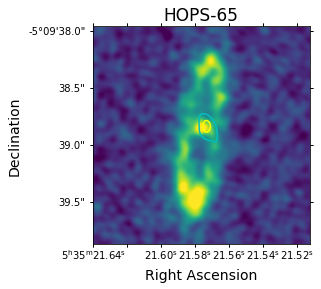

In [30]:
tested_obj = 'HOPS-65'

# parameter preparation for test objects
filename_345 = [f'data/{tested_obj}_345GHz.fits']
filename_33 = [f'data/{tested_obj}_{int(VLA_freq[tested_obj])}GHz_robust2.0.fits']

size_345 = [target_pixel_sizes[tested_obj]]
x_345 = [x_345s[tested_obj]]
y_345 = [y_345s[tested_obj]]
v_min = [v_mins[tested_obj]]
v_max = [v_maxs[tested_obj]]
rms_33 = [rms_VLAs[tested_obj]]
level = find_levels(rms_33, [np.array(n_levels[tested_obj])])


# get cutout and plot contour
cutout_345, cutout_33 = find_cutout(filename_345s=filename_345, filename_33s=filename_33, size_345s=size_345,
                                    x_345s=x_345, y_345s=y_345)
axs = gen_axis(cutout_345)
plot_contour(tested_obj, axs, cutout_345, cutout_33, pixel_sizes=size_345, levs=level, vmins=v_min, vmaxs=v_max, save_fig=False)

# plot_disk(True)


In [40]:
# save plot for all disks
tested_objs = ['HH270MMS2','HOPS-56',  'HOPS-65', 'HOPS-124', 'HOPS-140', 'HOPS-157', 'HOPS-163']  
for tested_obj in tested_objs:

    # parameter preparation for test objects
    filename_345 = [f'data/{tested_obj}_345GHz.fits']
    filename_33 = [f'data/{tested_obj}_{int(VLA_freq[tested_obj])}GHz_robust2.0.fits']

    size_345 = [target_pixel_sizes[tested_obj]]
    x_345 = [x_345s[tested_obj]]
    y_345 = [y_345s[tested_obj]]
    v_min = [v_mins[tested_obj]]
    v_max = [v_maxs[tested_obj]]
    rms_33 = [rms_VLAs[tested_obj]]
    level = find_levels(rms_33, [np.array(n_levels[tested_obj])])

    # get cutout and plot contour
    cutout_345, cutout_33 = find_cutout(filename_345s=filename_345, filename_33s=filename_33, size_345s=size_345,
                                        x_345s=x_345, y_345s=y_345)
    axs = gen_axis(cutout_345)
    plot_contour(tested_obj, axs, cutout_345, cutout_33, pixel_sizes=size_345, levs=level, vmins=v_min, vmaxs=v_max, save_fig=True)


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keyword